## Section 1: First we try PyTorch Quantization. 
### This is the best available option as we will see, in terms of accuracy preservation. 
### However, the FBGEMM backend is not available of FPGA and other embedded systems. In the next section we will implement  Quantization from scratch 

In [2]:
# import required packages
import os
import time
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.prune as prune
import torchvision
from torchvision import transforms, datasets
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [20]:
# Load MNIST dataset

torch.manual_seed(0)
np.random.seed(0)
torch.use_deterministic_algorithms(True)
bs= 16 
transform_test = transforms.Compose([transforms.Resize(32),transforms.ToTensor(),
                                          transforms.Normalize((0.1309,), (0.2893,))])

trainset = datasets.MNIST(root='../../dataset', train=True, download=True, transform=transform_test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=False)
    
testset = datasets.MNIST(root='../../dataset', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False)

torch.Size([128, 1, 32, 32])
torch.Size([128])


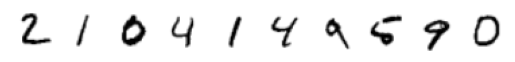

In [5]:
# Display some images
images, labels = next(iter(testloader))

print(images.shape)
print(labels.shape)

figure = plt.figure()
num_of_images = 10
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [6]:
# LeNet Model - Defined here upfront

class CNN_LeNet(nn.Module):
    def __init__(self):
        super(CNN_LeNet, self).__init__()
        # Define the net structure
        # This is the input layer first Convolution
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.fc1 = nn.Linear(400,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84, 10) 
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.reshape(-1, 400)
        #x = x.view(-1, 400)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # Outputs are dequantized
        x = F.softmax(x,dim=1)
        return x

In [24]:
# LeNet Model - I have created another version for quantized inference 

class CNN_LeNetQ(nn.Module):
    def __init__(self):
        super(CNN_LeNetQ, self).__init__()
        # Define the net structure
        # This is the input layer first Convolution
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.fc1 = nn.Linear(400,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84, 10) 
        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()

    
    def forward(self, x):
        x = self.quant(x)
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.reshape(-1, 400)
        #x = x.view(-1, 400)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # Outputs are dequantized
        x = self.dequant(x)
        x = F.softmax(x,dim=1)
        return x

In [7]:
# Load the pre-trained model 
pretrained_model = "./mnist_v0.pt"
net = CNN_LeNet()
net.load_state_dict(torch.load(pretrained_model))
state_dict = torch.load(pretrained_model)

In [9]:
# Helper function for getting the model size
def print_size_of_model(model):
    """ Print the size of the model.
    
    Args:
        model: model whose size needs to be determined

    """
    torch.save(model.state_dict(), "temp.p")
    print('Size of the model(KB):', os.path.getsize('temp.p')/1024)
    os.remove('temp.p')

In [10]:
print_size_of_model(net)

Size of the model(KB): 243.8193359375


In [12]:
# Main accuracy testing function
def test(model, device, test_loader, train_loader, batch_size, quantize=False, fbgemm=False):
    model.to(device)
    model.eval()
    
    # Testing with qauntization if quantize=True
    if quantize:
        if fbgemm:
            model.qconfig = torch.quantization.get_default_qconfig('fbgemm')
        else:
            model.qconfig = torch.quantization.default_qconfig
        torch.quantization.prepare(model, inplace=True)
        model.eval()
        with torch.no_grad():
            for data, target in train_loader:
                model.forward(data)
            torch.quantization.convert(model, inplace=True)
            print("======= Quantization Done =====")


    print(model)
    
    correct = 0
    total = 0
    with torch.no_grad():
        st = time.time()
        for data in test_loader:
            X, y = data
            st = time.time()
            output = model.forward(X)
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                #if True:
                    correct += 1
            total += batch_size
        et = time.time()    
    acc = round(correct/total, 4)
    print("========================================= PERFORMANCE =============================================")
    print_size_of_model(model)
    print("PyTorch optimized model test accuracy :{}% ".format(100*round(correct/total, 4)))
    print('Elapsed time = {:0.4f} milliseconds'.format((et - st) * 1000))
    print("====================================================================================================")

In [22]:
#Baseline performance - unquantized model
device = 'cpu'
test(model=net, device=device, test_loader=testloader, train_loader=trainloader, batch_size=bs)

CNN_LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
========================================= PERFORMANCE =============================================
Size of the model(KB): 243.8193359375
PyTorch optimized model test accuracy :99.03% 
Elapsed time = 0.6618 milliseconds


In [26]:
# Quantization Performance
# Load the model to be quantized with Pytorch Quantization
pretrained_modelq = "./mnist_v0.pt"
netq = CNN_LeNetQ()
netq.load_state_dict(torch.load(pretrained_modelq))
device = 'cpu'

# This performs the quantized inference. This is PyTorch static quantization. We only did activations quantization
# and performed the calibration required post training. The ACC drop is 0.03% only
test(model=netq, device=device, test_loader=testloader, train_loader=trainloader, batch_size=bs, quantize=True)

======= Quantization Done =====
CNN_LeNetQ(
  (conv1): QuantizedConv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), scale=0.1852394938468933, zero_point=87)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): QuantizedConv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), scale=0.3763515055179596, zero_point=65)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): QuantizedLinear(in_features=400, out_features=120, scale=0.6366482377052307, zero_point=68, qscheme=torch.per_tensor_affine)
  (fc2): QuantizedLinear(in_features=120, out_features=84, scale=0.5215939879417419, zero_point=43, qscheme=torch.per_tensor_affine)
  (fc3): QuantizedLinear(in_features=84, out_features=10, scale=0.8862839341163635, zero_point=61, qscheme=torch.per_tensor_affine)
  (quant): Quantize(scale=tensor([0.0272]), zero_point=tensor([17]), dtype=torch.quint8)
  (dequant): DeQuantize()
)
========================================= PERFORM

## Section 2: From scratch post training quantization - with calibration  
### As the FBGEMM backend is not available of FPGA and other embedded systems, we implement a simple quantization from scratch. We will take this to FPGA in the FPGA implementation 

In [30]:
# Routines for post training quantization - with calibration from scratch    
    
# Simple implementation for FPGA
# Routines for Quantization    
    
from collections import namedtuple
QTensor = namedtuple('QTensor', ['tensor', 'scale', 'zero_point'])
nb = 8
def calcScaleZeroPoint(min_val, max_val,num_bits=nb):
  # Calc Scale and zero point of next 
  qmin = 0.
  qmax = 2.**num_bits - 1. # potential math.pow() ?

  scale = (max_val - min_val) / (qmax - qmin)

  initial_zero_point = qmin - min_val / scale
  
  zero_point = 0
  if initial_zero_point < qmin:
      zero_point = qmin
  elif initial_zero_point > qmax:
      zero_point = qmax
  else:
      zero_point = initial_zero_point

  zero_point = int(zero_point)

  return scale, zero_point

def quantize_tensor(x, ndims=10, all_dims=[0], num_bits=nb, minmax=False, min_val=0.3711, max_val=-0.3977):
    if minmax:
        if ndims == 1:
            for i in range(all_dims[0]):
                if min_val > x[i].item():
                    min_val = x[i].item()
                if max_val < x[i].item():
                    max_val = x[i].item()
        elif ndims == 2:
            for i in range(all_dims[0]):
                for j in range(all_dims[1]):
                    if min_val > x[i][j].item():
                        min_val = x[i][j].item()
                    if max_val < x[i][j].item():
                        max_val = x[i][j].item()
        elif ndims == 3:
            for i in range(all_dims[0]):
                for j in range(all_dims[1]):
                    for k in range(all_dims[2]):
                        if min_val > x[i][j][k].item():
                            min_val = x[i][j][k].item()
                        if max_val < x[i][j][k].item():
                            max_val = x[i][j][k].item() 
        elif ndims == 4:
            for i in range(all_dims[0]):
                for j in range(all_dims[1]):
                    for k in range(all_dims[2]):
                        for l in range(all_dims[3]):
#                             print("i,j,k,l: ", i,j,k,l)
#                             print("i,j,k,l: ", all_dims[0],all_dims[1],all_dims[2],all_dims[3])
#                             print(x.shape)
                            if min_val > x[i][j][k][l].item():
                                min_val = x[i][j][k][l].item()
                            if max_val < x[i][j][k][l].item():
                                max_val = x[i][j][k][l].item() 
        else:
            print("unexpected dims: ", ndims, all_dims)
    #print("min, max :", min_val,  max_val )     
    qmin = 0.
    qmax = 2.**num_bits - 1.

    scale, zero_point = calcScaleZeroPoint(min_val, max_val, num_bits)
    q_x = zero_point + x / scale
    q_x.clamp_(qmin, qmax).round_()
    q_x = q_x.round().byte()
    
    return QTensor(tensor=q_x, scale=scale, zero_point=zero_point)

def dequantize_tensor(q_x):
    return q_x.scale * (q_x.tensor.float() - q_x.zero_point)
  # quantizeLayer(x.tensor, ndims, all_dims, model.conv1, stats['conv2'], x.scale, x.zero_point 
def quantizeLayer(x,  layer, stat, scale_x, zp_x, num_bits=nb):
  # for both conv and linear layers
  W = layer.weight.data
  B = layer.bias.data

  # scale_x = x.scale
  # zp_x = x.zero_point


  # Find the dimensions for the input
  ndims = len(W.shape)
  all_dims = list(W.shape)
  #print("ndims, all_dims: ",ndims, all_dims)
  w = quantize_tensor(layer.weight.data, ndims, all_dims, num_bits, minmax=True) 
  ndims = len(B.shape)
  all_dims = list(B.shape)
  #print("ndims, all_dims: ",ndims, all_dims)
  b = quantize_tensor(layer.bias.data, ndims, all_dims, num_bits, minmax=True)

  layer.weight.data = w.tensor.float()
  layer.bias.data = b.tensor.float()

  ####################################################################
  # This is Quantisation !!!!!!!!!!!!!!!!!!!!!!!!!!!!!

  scale_w = w.scale
  zp_w = w.zero_point
  
  scale_b = b.scale
  zp_b = b.zero_point
  

  scale_next, zero_point_next = calcScaleZeroPoint(min_val=stat['min'], max_val=stat['max'])

  # Perparing input by shifting
  X = x.float() - zp_x
  layer.weight.data = (scale_x * scale_w/scale_next)*(layer.weight.data - zp_w)
  layer.bias.data = (scale_b/scale_next)*(layer.bias.data + zp_b)

  # All int

  x = layer(X) + zero_point_next
  x = F.relu(x)  
    
  # Reset
  layer.weight.data = W
  layer.bias.data = B
  
  return x, scale_next, zero_point_next


def quantForward(model, x, stats):
    
  # Quantise before inputting into incoming layers
  x = quantize_tensor(x, min_val=stats['conv1']['min'], max_val=stats['conv1']['max'])
    
  x, scale_next, zero_point_next = quantizeLayer(x.tensor, model.conv1, stats['conv2'], x.scale, x.zero_point)
  x = F.max_pool2d(x, 2, 2)
  x, scale_next, zero_point_next = quantizeLayer(x,  model.conv2, stats['fc1'], scale_next, zero_point_next)
  x = F.max_pool2d(x, 2, 2)
  x = x.reshape(-1, 400)  
  x, scale_next, zero_point_next = quantizeLayer(x, model.fc1, stats['fc2'], scale_next, zero_point_next)
  x, scale_next, zero_point_next = quantizeLayer(x, model.fc2, stats['fc3'], scale_next, zero_point_next)
    
  
  # Back to dequant for final layer
  x = dequantize_tensor(QTensor(tensor=x, scale=scale_next, zero_point=zero_point_next))
   
  x = model.fc3(x)
  x = F.softmax(x,dim=1)
  return x

def test_quant_scratch(model, device, test_loader, train_loader, batch_size, quantize=False, fbgemm=False, stats=None):
    model.to(device)
    model.eval()
    
    print(model)
    
    correct = 0
    total = 0
    with torch.no_grad():
        st = time.time()
        for data in test_loader:
            X, y = data
            #st = time.time()
            # Testing with qauntization if quantize=True
            if quantize:
                output = quantForward(model, X, stats)
            else:    
                output = model.forward(X)
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                #if True:
                    correct += 1
            total += batch_size
        et = time.time()    
    acc = round(correct/total, 4)
    print("========================================= PERFORMANCE =============================================")
    print_size_of_model(model)
    print("PyTorch optimized model test accuracy :{}% ".format(100*round(correct/total, 4)))
    print('Elapsed time = {:0.4f} milliseconds'.format((et - st) * 1000))
    print("====================================================================================================")

    

In [31]:
# Quantized model performance
# Copy from the original model for Q
import copy
netqq = copy.deepcopy(net)

# one time stats gathering - we will keep this stored for MNIST FPGA implementation
# This is doing the required calibration for finding the min, max of the activations
stats = gatherStats(netqq, trainloader)
print(stats)

{'conv1': {'max': tensor(47.7186), 'min': tensor(-7.2398)}, 'conv2': {'max': tensor(99.3117), 'min': tensor(0.)}, 'fc1': {'max': tensor(207.4083), 'min': tensor(0.)}, 'fc2': {'max': tensor(280.4087), 'min': tensor(0.)}, 'fc3': {'max': tensor(336.0337), 'min': tensor(0.)}}


In [32]:
# Quantized Inference
test_quant_scratch(model=netqq, device=device, test_loader=testloader, train_loader=trainloader, batch_size=bs, quantize=True, stats=stats)

CNN_LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
========================================= PERFORMANCE =============================================
Size of the model(KB): 243.8193359375
PyTorch optimized model test accuracy :99.05000000000001% 
Elapsed time = 184712.4412 milliseconds


###  We get better performance than the PyTorch inference, with both activation and weight quantization. We will take this to FPGA

## Section 3: DietCNN Inference - Multiplication Free 
### The main efficacy of this is in the FPGA implementation. 

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import transforms, datasets
import os
# For training
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision
from torchvision import utils
import sys
sys.path.insert(1, '../core')
from typing import Type, Any, Callable, Union, List, Optional
from torch import Tensor
#from mnist_modeldef import *
from mnist_modeldef_full import *
from  patchlib import *
import faiss 
       
import os
import numpy
import random
import time

In [34]:
# Test method for the DietCNN MNIST Network. Stand alone Python file is also provided 
# with instrumentation functions for MNIST DietCNN inference
HOWDY = 20000000 

# Test accuracy of symbolic inference
def test_fullsym_acc(model, atk,  data_iter, batch_size, clamp, top_5, std):
    correct = 0 
    total = 0 
    counter = 0
    model.eval()
    for data in data_iter:
        X, y = data
        if counter > HOWDY:
            break
        if(clamp):
            X = softclamp01(X)
        if atk:
            X_atk = atk(X, y)
            X_sym = X_atk.data.cpu().numpy().copy()
        else:
            X_atk = X
            X_sym = X  

        output = model.forward(X)
        if not top_5:
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                #if True:
                    correct += 1
        else:
           top5op = output.detach().numpy()
           for idx, i in enumerate(top5op):
               ind = np.argpartition(i, -5)[-5:]
               for j in ind:
                   flag = 0
                   if j == y[idx]:
                       correct += 1
            #else:
            #    # Whenever there is an error, print the image
            #    print("Test Image #: {}".format(total+1))
            #    print("Mispredicted label: {}".format(torch.argmax(i)))
        counter +=batch_size 
        total += batch_size
        if std == 0: 
            if not top_5:
                if(counter > 0 and counter % batch_size == 0):
                    print("PyTorch optimized model test accuracy :{}% ".format(100*round(correct/total, 4)))
            else:
                if(counter > 0 and counter % batch_size == 0):
                    print("PyTorch  model test accuracy Top-5 :{}% ".format(100*round(correct/total, 4)))
        elif std == 1: 
            if not top_5:
                if(counter > 0 and counter % batch_size == 0):
                    print("Full standard model test accuracy :{}% ".format(100*round(correct/total, 4)))
            else:
                if(counter > 0 and counter % batch_size == 0):
                    print("Full standard  model test accuracy Top-5 :{}% ".format(100*round(correct/total, 4)))
        else:
            if not top_5:
                if(counter > 0 and counter % batch_size == 0):
                    print("Full symbolic model test accuracy DietCNN :{}% ".format(100*round(correct/total, 4)))
            else:
                if(counter > 0 and counter % batch_size == 0):
                    print("Full symbolic model test accuracy Top-5 DietCNN :{}% ".format(100*round(correct/total, 4)))
        #break 
    return round(correct/total, 4)

In [35]:
# DietCNN HyperParameters - 3 main 
# 1. Image  and all activation symbols 
# 2 & 3. Symbols for CONV and FC layers dictionary 

index = faiss.read_index("./kmeans_mnist_fullnet_k1_s1_c128_faiss_v10.index")
#n_clusters=512
n_clusters=128

# using a single pixel patch as of now
patch_size = (1, 1)
patch_stride = 1

# this is the reverse dictionary - symbol to patch 
centroid_lut = index.reconstruct_n(0, n_clusters)

# Pre-trained DietCNN model
pretrained_model = "./best_lenet_full.pt"

# Load the standard model
net = CNN_LeNet()
net.load_state_dict(torch.load(pretrained_model))
state_dict = torch.load(pretrained_model)


# Extract the filters
c1_filter = net.conv1.weight.data.clone()
c1_bias = net.conv1.bias.clone()
c2_filter = net.conv2.weight.data.clone()
c2_bias = net.conv2.bias.clone()

f1_filter = net.fc1.weight.data.clone()
f2_filter = net.fc2.weight.data.clone()
f3_filter = net.fc3.weight.data.clone()

# Load the CONV and FC dictionaries and the LUT that are created already
import pickle
conv_patch_size = (1, 1)
n_cluster_conv_filters = 64
n_cluster_fc_filters = 128
#n_cluster_fc_filters = 256
conv_stride = 1
with open("mnist_conv_flt_full.index", "rb") as f:
    filter_index_conv = pickle.load(f)
with open("mnist_fc_flt_full.index", "rb") as f:
    filter_index_fc = pickle.load(f)
fc_lut = np.genfromtxt('./mnist_fc_lut_full.txt', delimiter=',',dtype=np.int16) 
conv_lut = np.genfromtxt('./mnist_conv_lut_full.txt', delimiter=',',dtype=np.int16) 
add_lut = np.genfromtxt('./mnist_add_lut_full.txt', delimiter=',',dtype=np.int16) 
relu_lut = np.genfromtxt('./mnist_relu_lut_full.txt', delimiter=',',dtype=np.int16)
c1blut = np.genfromtxt('./mnist_c1_bias_lut_full.txt', delimiter=',',dtype=np.int16)
c2blut = np.genfromtxt('./mnist_c2_bias_lut_full.txt', delimiter=',',dtype=np.int16)
f1blut = np.genfromtxt('./mnist_f1_bias_lut_full.txt', delimiter=',',dtype=np.int16)
f2blut = np.genfromtxt('./mnist_f2_bias_lut_full.txt', delimiter=',',dtype=np.int16)

# this is the creation of symbolic model.
# All these steps are need in the desktop implementation to sync with PyTorch inference
# For FPGA implementation the DietCNN models are quite simple 

netsym = lenet_sym(net,state_dict, filter_index_conv, filter_index_fc, conv_lut, fc_lut, add_lut, c1blut,c2blut, f1blut,f2blut,relu_lut, n_clusters, index, centroid_lut, patch_size, patch_stride, False)
netsym.eval()
start_t = time.time()  
acc = test_fullsym_acc(netsym, None, testloader, bs, False, False, 1)
end = time.time()
print("elapsed time for symbolic inference:", end - start_t) 

Full standard model test accuracy :100.0% 
Full standard model test accuracy :96.88% 
Full standard model test accuracy :97.92% 
Full standard model test accuracy :98.44000000000001% 
Full standard model test accuracy :98.75% 
Full standard model test accuracy :98.96000000000001% 
Full standard model test accuracy :99.11% 
Full standard model test accuracy :99.22% 
Full standard model test accuracy :99.31% 
Full standard model test accuracy :99.38% 
Full standard model test accuracy :99.42999999999999% 
Full standard model test accuracy :99.48% 
Full standard model test accuracy :99.52% 
Full standard model test accuracy :99.55000000000001% 
Full standard model test accuracy :99.58% 
Full standard model test accuracy :99.22% 
Full standard model test accuracy :98.9% 
Full standard model test accuracy :98.96000000000001% 
Full standard model test accuracy :98.68% 
Full standard model test accuracy :98.75% 
Full standard model test accuracy :98.50999999999999% 
Full standard model test a

Full standard model test accuracy :97.77% 
Full standard model test accuracy :97.75% 
Full standard model test accuracy :97.72% 
Full standard model test accuracy :97.7% 
Full standard model test accuracy :97.72% 
Full standard model test accuracy :97.72999999999999% 
Full standard model test accuracy :97.71% 
Full standard model test accuracy :97.72% 
Full standard model test accuracy :97.7% 
Full standard model test accuracy :97.71% 
Full standard model test accuracy :97.69% 
Full standard model test accuracy :97.7% 
Full standard model test accuracy :97.71% 
Full standard model test accuracy :97.72% 
Full standard model test accuracy :97.74000000000001% 
Full standard model test accuracy :97.75% 
Full standard model test accuracy :97.76% 
Full standard model test accuracy :97.77% 
Full standard model test accuracy :97.78% 
Full standard model test accuracy :97.78999999999999% 
Full standard model test accuracy :97.77% 
Full standard model test accuracy :97.78% 
Full standard model t

Full standard model test accuracy :98.04% 
Full standard model test accuracy :98.04% 
Full standard model test accuracy :98.05% 
Full standard model test accuracy :98.05% 
Full standard model test accuracy :98.06% 
Full standard model test accuracy :98.05% 
Full standard model test accuracy :98.05% 
Full standard model test accuracy :98.06% 
Full standard model test accuracy :98.06% 
Full standard model test accuracy :98.05% 
Full standard model test accuracy :98.04% 
Full standard model test accuracy :98.04% 
Full standard model test accuracy :98.05% 
Full standard model test accuracy :98.06% 
Full standard model test accuracy :98.04% 
Full standard model test accuracy :98.05% 
Full standard model test accuracy :98.05% 
Full standard model test accuracy :98.06% 
Full standard model test accuracy :98.06% 
Full standard model test accuracy :98.07000000000001% 
Full standard model test accuracy :98.07000000000001% 
Full standard model test accuracy :98.08% 
Full standard model test accur

Full standard model test accuracy :98.45% 
Full standard model test accuracy :98.45% 
Full standard model test accuracy :98.45% 
Full standard model test accuracy :98.46000000000001% 
Full standard model test accuracy :98.46000000000001% 
Full standard model test accuracy :98.46000000000001% 
Full standard model test accuracy :98.47% 
Full standard model test accuracy :98.47% 
Full standard model test accuracy :98.47% 
Full standard model test accuracy :98.47% 
Full standard model test accuracy :98.48% 
Full standard model test accuracy :98.48% 
Full standard model test accuracy :98.48% 
Full standard model test accuracy :98.49% 
Full standard model test accuracy :98.49% 
Full standard model test accuracy :98.49% 
Full standard model test accuracy :98.49% 
Full standard model test accuracy :98.5% 
Full standard model test accuracy :98.5% 
Full standard model test accuracy :98.5% 
Full standard model test accuracy :98.49% 
Full standard model test accuracy :98.48% 
Full standard model t